# Features engineering <font style="font-size:.5em">_• Daily Weather Observations_</font>

In [1]:
# imports, conf. & base dataset (df)
import os
import sys
sys.path.insert(0, os.path.abspath("../lib"))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(rc={"figure.dpi":72, 'savefig.dpi':200})
sns.set_theme(font_scale=1.25)

from ozpydry.display import md
from ozpydry.metrics import ClfReport
from ozpydry.model_selection import sample_tts

# Load dataset
from ozpydry.model_selection import load_df
df = load_df()

## Samples balancing
_The naive attempt_

Notre première approche sera de tester quelques modèles "simples" sur un jeu de données réduit équilibré / non équilibré (état par défaut). Nous évitons ainsi des temps de calculs coûteux.

Nous mettrons ensuite en lumière les features à retenir par l'interpretation de modèles comparés aux conclusions formulées dans le rapport d'exploration.

In [3]:
# Testing un/balanced data on KNeighbors classifier
from sklearn.neighbors import KNeighborsClassifier

report = ClfReport('./reports/balancing-report')

# KNClassifier(k=5) unbalanced
Xs, Xt, ys, yt = sample_tts()
knc = KNeighborsClassifier()
knc.fit(Xs, ys)
report(knc, (Xs, Xt, ys, yt), "KNClassifier(k=5)", False)

# KNClassifier(k=5) balanced (undersampled)
Xs, Xt, ys, yt = sample_tts('under')
knc = KNeighborsClassifier()
knc.fit(Xs, ys)
report(knc, (Xs, Xt, ys, yt), "KNClassifier(k=5) undersampled", False)

# KNClassifier(k=5) balanced (oversampled)
Xs, Xt, ys, yt = sample_tts('over')
knc = KNeighborsClassifier()
knc.fit(Xs, ys)
report(knc, (Xs, Xt, ys, yt), "KNClassifier(k=5) oversampled", False)

report.show()

<div class="rt">

|||pre|rec|spe|f1|geo|iba|sup|
|-|-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|KNClassifier(k=5)|||||||||
|_78% balance_|0|0.93|0.87|0.69|0.90|0.78|0.61|9404|
|_22% balance_|1|0.52|0.69|0.87|0.60|0.78|0.59|1880|
||avg / total|0.87|0.84|0.72|0.85|0.78|0.61||
||test accuracy||||0.84||||
||train accuracy||||0.88||||
|KNClassifier(k=5) undersampled|||||||||
|_50% balance_|0|0.78|0.92|0.50|0.85|0.68|0.48|7419|
|_50% balance_|1|0.77|0.50|0.92|0.61|0.68|0.44|3865|
||avg / total|0.78|0.78|0.64|0.76|0.68|0.47||
||test accuracy||||0.78||||
||train accuracy||||0.85||||
|KNClassifier(k=5) oversampled|||||||||
|_50% balance_|0|0.78|0.91|0.48|0.84|0.66|0.46|7478|
|_50% balance_|1|0.74|0.48|0.91|0.58|0.66|0.42|3806|
||avg / total|0.76|0.77|0.63|0.75|0.66|0.45||
||test accuracy||||0.77||||
||train accuracy||||0.90||||

</div>
        <style>
            .rt { color:#444; }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt tr:nth-child(6n+1) {color:black;}
            .rt th + th, .rt td + td { border-right: 4px solid white; }
            .rt tr:first-child th + th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

#### Note

Sans recherche des hyper-paramètres optimaux, le jeu de données non équilibré donne un résulat plus homogène pour la classe sous-peuplée (cf. précision, recall et geometric mean). Le re-échantillonage semble tendre vers un overfitting et déséquilibre la précision et le recall de la classe minoritaire. Nous poursuivons donc en conservant le déséquilibre du jeu de données.

## Features exploration

Nous entrainons une régression logistique et un arbre de décision. Ces deux classifieurs vont nous servir à visualiser l'importance attribuée à chacune des variables explicatives.

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

report = ClfReport('./reports/feature-sel-report')

# fit logistic regression with normalized data
Xs, Xt, ys, yt = sample_tts()
sc = StandardScaler()
Xs = sc.fit_transform(Xs) # keep feature names
Xt = sc.transform(Xt)
lrg = LogisticRegression(max_iter=200)
lrg.fit(Xs, ys)
report(lrg, (Xs, Xt, ys, yt), 'LogiticReg (minmax norm.)', False)

# fit a decision tree with discretised categorials
Xs, Xt, ys, yt = sample_tts(encode='discrete')
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(Xs, ys)
report(dtc, (Xs, Xt, ys, yt), 'DecisionTree(d=10)', False)

report.show()

<div class="rt">

|||pre|rec|spe|f1|geo|iba|sup|
|-|-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|LogiticReg (minmax norm.)|||||||||
|_78% balance_|0|0.95|0.88|0.74|0.91|0.81|0.66|9478|
|_22% balance_|1|0.54|0.74|0.88|0.62|0.81|0.64|1806|
||avg / total|0.88|0.86|0.76|0.87|0.81|0.66||
||test accuracy||||0.86||||
||train accuracy||||0.86||||
|DecisionTree(d=10)|||||||||
|_78% balance_|0|0.94|0.87|0.68|0.90|0.77|0.60|9494|
|_22% balance_|1|0.49|0.68|0.87|0.57|0.77|0.58|1790|
||avg / total|0.87|0.84|0.71|0.85|0.77|0.60||
||test accuracy||||0.84||||
||train accuracy||||0.89||||

</div>
        <style>
            .rt { color:#444; }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt tr:nth-child(6n+1) {color:black;}
            .rt th + th, .rt td + td { border-right: 4px solid white; }
            .rt tr:first-child th + th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

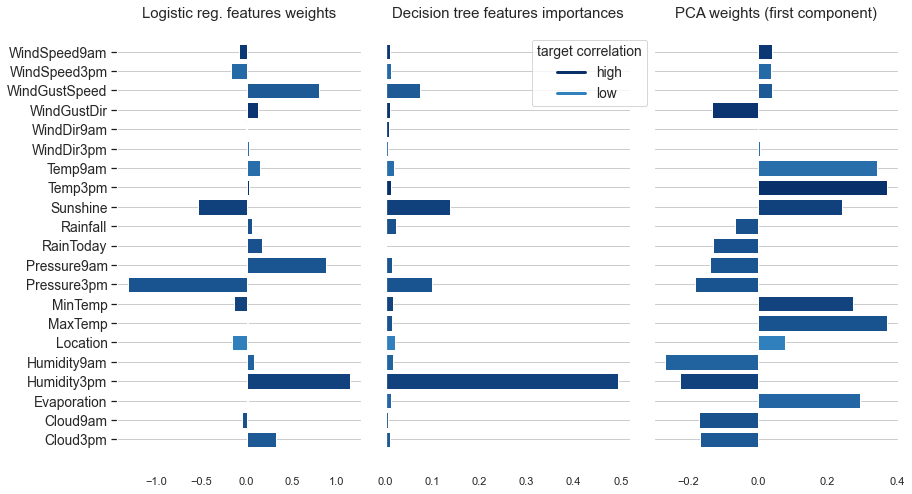

In [ ]:
# Feature weights/importances charts
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Build a colormap from correlation matrix, thus we can color features
# with their degree of correlation to target.
cr = df.drop(columns='Date')
cats = ['Location','RainToday','WindDir3pm','WindDir9am','WindGustDir','RainTomorrow']
cr[cats] = cr[cats].astype('category').apply(lambda f: f.cat.codes)
cr = cr.corr().loc['RainTomorrow'].drop('RainTomorrow')
norm = plt.Normalize(cr.min(), cr.max())
cmap = LinearSegmentedColormap.from_list("featCor", ['#3080BD', '#08306B'])
colors = cr.apply(lambda x: cmap(norm(x)))

# Setup a figure (1x3 subplots)
fig, axs = plt.subplots(1, 3, figsize=(14,8), sharey=True, gridspec_kw={'wspace':.1})
for ax in axs:
    ax.set(facecolor='w')
    ax.grid(True, color='#CCC', which='major', axis='y')
    ax.xaxis.set_tick_params(labelsize=11)

axs[0].tick_params(left=True, color='k')
axs[0].set_title("Logistic reg. features weights")
axs[1].set_title("Decision tree features importances")
axs[2].set_title("PCA weights (first component)")

# Indices bounds of Onehot encoded features (to remaps as initial)
cat_rng = [('Location',17,43), ('WindGustDir',43,59), ('WindDir9am',59,75), ('WindDir3pm',75,91)]

# Logistic reg. features weights
Xs, _, _, _  = sample_tts()
cf = pd.DataFrame(lrg.coef_, columns=Xs.columns)
cm = pd.DataFrame()
for k, i, j in cat_rng:
    cm[k] = cf.iloc[:,i:j].sum(axis=1)

cf = cf.iloc[:,:17].join(cm)
cf = cf.reindex(sorted(cf.columns), axis=1)
axs[0].barh(y=cf.columns, width=cf.iloc[0], color=colors)

# Dtree features importances
cf = pd.DataFrame([dtc.feature_importances_], columns=dtc.feature_names_in_)
cf = cf.reindex(sorted(cf.columns), axis=1)
axs[1].barh(y=cf.columns, width=cf.iloc[0], color=colors);

# PCA weights (first component)
Xs, _, _, _  = sample_tts()
Xs.iloc[:,:] = sc.transform(Xs.copy())
pca = PCA()
pca.fit(Xs)
cf = pd.DataFrame(pca.components_, columns=Xs.columns, index = pca.get_feature_names_out())
cm = pd.DataFrame()
for k, i, j in cat_rng:
    cm[k] = cf.iloc[:,i:j].sum(axis=1)
cf = cf.iloc[:,:17].join(cm)
cf = cf.reindex(sorted(cf.columns), axis=1)
axs[2].barh(y=cf.columns, width=cf.iloc[0], color=colors)

# Add legend
hds = [Line2D([0], [0], color=cmap(1.), lw=3), Line2D([0], [0], color=cmap(0.), lw=3)]
axs[2].legend(hds, ['high', 'low'], facecolor='w', bbox_to_anchor=(0., .98),
                    title="target correlation", title_fontsize=14);

plt.savefig('./output/features-importances.png')


#### Note

Sans surprise, les variables les plus corrélées avec la cible se voient attribuer un coéfficient de régression fort.

Notons les corrélations entre les variables explicatives suivantes (cf. rapport d'exploration) :
- _Cloud3pm Cloud9am_
- _Humidity3pm Humidity9am_
- _MaxTemp MinTemp Temp3pm Temp9am_
- _WindGustSpeed WindSpeed3pm WindSpeed9_


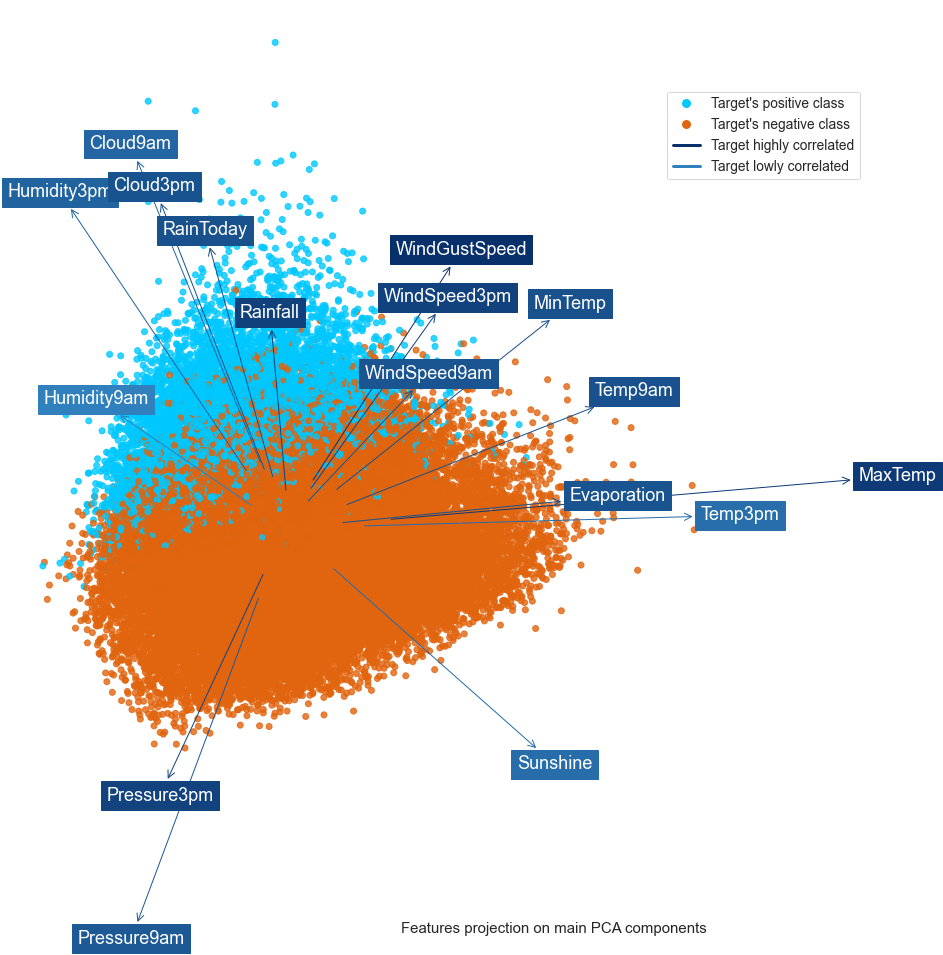

In [30]:
# PCA
# Prepare plot
_, ax = plt.subplots(figsize=(14, 14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_facecolor('white')
ax.grid(False)

Xs, _, ys, _  = sample_tts(drop=[c for c, _, _ in cat_rng])
feat = Xs.columns # before we lost them into scaling and pca...
Xs = StandardScaler().fit_transform(Xs)

ys = LogisticRegression().fit(Xs, ys).predict(Xs)
pca = PCA(2)
Xs = pca.fit_transform(Xs)

# Plot predictions (re-scale to match pca coef. range)
x = Xs[:,0] * 1. / np.ptp(Xs[:,0]) / 1.2
y = Xs[:,1] * 1. / np.ptp(Xs[:,1]) / 1.2
ax.scatter(x, y, c=np.where(ys == 1, "#00C8FF", "#E1640E"), alpha=.8)

# Compile x, y & mag for annotations
coef = pca.components_
coef = np.array([coef[0,], coef[1,], np.linalg.norm(coef, axis=0)]).T

# Attempt to prevent overlaping text boxes
for i in range(coef.shape[0]):
    a = coef[i]
    for j in range(i):
        b = coef[j]
        if np.linalg.norm(a[:-1] - b[:-1]) < 0.1:
            t = i if a[2] > b[2] else j
            coef[t,:-1] = coef[t,:-1] * (min(a[2], b[2]) / max(a[2], b[2]) + .4)

# Plots in correct z-order (argsort(|v|))
for i in np.flip(coef[:,2].argsort()):
    x = coef[i, 0]
    y = coef[i, 1] # TODO: check corr. colors (color=colors[i])
    plt.annotate(feat[i], xy=(x/6, y/6), xytext=(x, y), color='w', fontsize=18,
                 bbox=dict(boxstyle="square", color=colors[i], alpha=1),
                 arrowprops=dict(arrowstyle="<-", color=colors[i], linewidth=1))

# Add legend
hds = [Line2D([0],[0], marker="o", markersize=10, color="w", markerfacecolor="#00C8FF", label="Target's positive class"),
       Line2D([0],[0], marker="o", markersize=10, color="w", markerfacecolor="#E1640E", label="Target's negative class"),
       Line2D([0],[0], color=cmap(1.), lw=3, label="Target highly correlated"),
       Line2D([0],[0], color=cmap(0.), lw=3, label="Target lowly correlated")]
ax.legend(handles=hds, facecolor='w', bbox_to_anchor=(1.1, .9));
plt.title("Features projection on main PCA components", x=.7, y=-.2);

plt.savefig("./output/pca-features-projection.png")

In [581]:
# Fulls featured models comparison with and without PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

report = ClfReport('./reports/pca-unbalanced', True)
load_df(extras='climate')

estimators = [('KNeighbors', KNeighborsClassifier()),
              ('DecisionTree', DecisionTreeClassifier()),
              ('LogisticRegression', LogisticRegression(max_iter=2000)),
              ('GaussianNB', GaussianNB()),
              ('RandomForest', RandomForestClassifier()),
              ('AdaBoost', AdaBoostClassifier())]

for id, clf in estimators:

    Xs, Xt, ys, yt = sample_tts(dt='B')
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), id, show=False)

    pca = PCA(.9).fit(Xs)
    Xs = pca.transform(Xs)
    Xt = pca.transform(Xt)

    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "%s • PCA(.9)" % id, show=False)

report.show(compact=True, tone=True, title="Full features - No vs PCA")

<div class="rt">

|Full features - No vs PCA|test<br>acc.|train<br>acc.|0<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|1<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|<br>% bal.|<br>obs|
|-|:-:|:-:|:-:|:-:|:-:|:-|
|KNeighbors|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.88">0.88</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.52">0.52</i>&nbsp;&nbsp;<i class="v c" style="--v:0.70">0.70</i>&nbsp;&nbsp;<i class="v c" style="--v:0.60">0.60</i>|<small>78 / 22</small>|<small>45136</small>|
|KNeighbors • PCA(.9)|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.88">0.88</i>|<i class="v c" style="--v:0.93">0.93</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>|<i class="v c" style="--v:0.49">0.49</i>&nbsp;&nbsp;<i class="v c" style="--v:0.65">0.65</i>&nbsp;&nbsp;<i class="v c" style="--v:0.56">0.56</i>|<small>78 / 22</small>|<small>45136</small>|
|DecisionTree|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.56">0.56</i>&nbsp;&nbsp;<i class="v c" style="--v:0.53">0.53</i>&nbsp;&nbsp;<i class="v c" style="--v:0.54">0.54</i>|<small>78 / 22</small>|<small>45136</small>|
|DecisionTree • PCA(.9)|<i class="v c" style="--v:0.78">0.78</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.52">0.52</i>&nbsp;&nbsp;<i class="v c" style="--v:0.50">0.50</i>&nbsp;&nbsp;<i class="v c" style="--v:0.51">0.51</i>|<small>78 / 22</small>|<small>45136</small>|
|LogisticRegression|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.54">0.54</i>&nbsp;&nbsp;<i class="v c" style="--v:0.74">0.74</i>&nbsp;&nbsp;<i class="v c" style="--v:0.62">0.62</i>|<small>78 / 22</small>|<small>45136</small>|
|LogisticRegression • PCA(.9)|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.48">0.48</i>&nbsp;&nbsp;<i class="v c" style="--v:0.73">0.73</i>&nbsp;&nbsp;<i class="v c" style="--v:0.58">0.58</i>|<small>78 / 22</small>|<small>45136</small>|
|GaussianNB|<i class="v c" style="--v:0.70">0.70</i>|<i class="v c" style="--v:0.69">0.69</i>|<i class="v c" style="--v:0.69">0.69</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>&nbsp;&nbsp;<i class="v c" style="--v:0.78">0.78</i>|<i class="v c" style="--v:0.76">0.76</i>&nbsp;&nbsp;<i class="v c" style="--v:0.41">0.41</i>&nbsp;&nbsp;<i class="v c" style="--v:0.53">0.53</i>|<small>78 / 22</small>|<small>45136</small>|
|GaussianNB • PCA(.9)|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.44">0.44</i>&nbsp;&nbsp;<i class="v c" style="--v:0.72">0.72</i>&nbsp;&nbsp;<i class="v c" style="--v:0.54">0.54</i>|<small>78 / 22</small>|<small>45136</small>|
|RandomForest|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.96">0.96</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.52">0.52</i>&nbsp;&nbsp;<i class="v c" style="--v:0.78">0.78</i>&nbsp;&nbsp;<i class="v c" style="--v:0.63">0.63</i>|<small>78 / 22</small>|<small>45136</small>|
|RandomForest • PCA(.9)|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.49">0.49</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>&nbsp;&nbsp;<i class="v c" style="--v:0.58">0.58</i>|<small>78 / 22</small>|<small>45136</small>|
|AdaBoost|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.52">0.52</i>&nbsp;&nbsp;<i class="v c" style="--v:0.72">0.72</i>&nbsp;&nbsp;<i class="v c" style="--v:0.61">0.61</i>|<small>78 / 22</small>|<small>45136</small>|
|AdaBoost • PCA(.9)|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.48">0.48</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>&nbsp;&nbsp;<i class="v c" style="--v:0.57">0.57</i>|<small>78 / 22</small>|<small>45136</small>|

</div>
        <style>
            .rt { color:#444; }
            .rt .v { padding:2px; font-style:normal; }
            .rt .c { color:#222; background:hsl(calc(((var(--v) - .5) / .5) * 120), 70%, 85%, calc(var(--v))); }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt th, .rt td { border-right: 4px solid white; }
            .rt tr:first-child th:first-child { font-size:.8em;font-weight:normal;text-align:left; }
            .rt td:first-child { text-align:right; }
            .rt tr:first-child th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

Avec PCA, nous notons une baisse d'accuracy, precision et recall pour tous les estimateurs testés, excepté pour le GaussianNB.

### Apport de la feature 'climate'

Examinons si le partionnement des données basé sur classification climatique de Köppen apporte un quelquonque gain.

Nous testerons 9 modèles entrainés sur les 9 zones climatiques (revélées lors de la phase d'analyse) plus 3 modèles entrainés sur les "meta-zones": aride, tempérée et tropicale.

In [616]:
# Fit one model by climate (LogReg)
from sklearn.linear_model import LogisticRegression

report = ClfReport('./reports/per-climate-model', True)

df = load_df(extras='climate')
kcodes = df.KCode.sort_values().unique()

# One model fit by first letter k-code (ie. A,B,C)
for kc in sorted(set([x[0] for x in kcodes])):
    clf = LogisticRegression(max_iter=1000)

    Xs, Xt, ys, yt = sample_tts(prior=lambda df: df[df.KCode.str[0] == kc], drop=['KCode'], scale=True)
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "__%s__" % kc, show=False)

    # One model fit by 'sub' climate (ie. Am, Aw..)
    for kcs in [x for x in kcodes if x[0] == kc]:
        Xs, Xt, ys, yt = sample_tts(prior=lambda df: df[df.KCode == kcs], drop=['KCode'], scale=True)
        report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "%s" % kcs, show=False)

report.show(compact=True, tone=True, title="Per climate model _(LogReg.)_")

<div class="rt">

|Per climate model _(LogReg.)_|test<br>acc.|train<br>acc.|0<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|1<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|<br>% bal.|<br>obs|
|-|:-:|:-:|:-:|:-:|:-:|:-|
|__A__|<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.65">0.65</i>&nbsp;&nbsp;<i class="v c" style="--v:0.77">0.77</i>&nbsp;&nbsp;<i class="v c" style="--v:0.70">0.70</i>|<small>76 / 24</small>|<small>6340</small>|
|Am|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>|<i class="v c" style="--v:0.65">0.65</i>&nbsp;&nbsp;<i class="v c" style="--v:0.79">0.79</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>|<small>69 / 31</small>|<small>1955</small>|
|Aw|<i class="v c" style="--v:0.88">0.88</i>|<i class="v c" style="--v:0.88">0.88</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.63">0.63</i>&nbsp;&nbsp;<i class="v c" style="--v:0.76">0.76</i>&nbsp;&nbsp;<i class="v c" style="--v:0.69">0.69</i>|<small>78 / 22</small>|<small>4384</small>|
|__B__|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.97">0.97</i>|<i class="v c" style="--v:0.51">0.51</i>&nbsp;&nbsp;<i class="v c" style="--v:0.75">0.75</i>&nbsp;&nbsp;<i class="v c" style="--v:0.60">0.60</i>|<small>91 / 9</small>|<small>5668</small>|
|BSh|<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.95">0.95</i>|<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.93">0.93</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>|<i class="v c" style="--v:0.46">0.46</i>&nbsp;&nbsp;<i class="v c" style="--v:0.75">0.75</i>&nbsp;&nbsp;<i class="v c" style="--v:0.57">0.57</i>|<small>88 / 12</small>|<small>427</small>|
|BSk|<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.93">0.93</i>|<i class="v c" style="--v:0.97">0.97</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>|<i class="v c" style="--v:0.48">0.48</i>&nbsp;&nbsp;<i class="v c" style="--v:0.68">0.68</i>&nbsp;&nbsp;<i class="v c" style="--v:0.57">0.57</i>|<small>89 / 11</small>|<small>2075</small>|
|BWh|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.95">0.95</i>|<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.96">0.96</i>&nbsp;&nbsp;<i class="v c" style="--v:0.97">0.97</i>|<i class="v c" style="--v:0.52">0.52</i>&nbsp;&nbsp;<i class="v c" style="--v:0.66">0.66</i>&nbsp;&nbsp;<i class="v c" style="--v:0.58">0.58</i>|<small>92 / 8</small>|<small>3165</small>|
|__C__|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.55">0.55</i>&nbsp;&nbsp;<i class="v c" style="--v:0.74">0.74</i>&nbsp;&nbsp;<i class="v c" style="--v:0.63">0.63</i>|<small>76 / 24</small>|<small>33128</small>|
|Cfa|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.54">0.54</i>&nbsp;&nbsp;<i class="v c" style="--v:0.72">0.72</i>&nbsp;&nbsp;<i class="v c" style="--v:0.62">0.62</i>|<small>77 / 23</small>|<small>12155</small>|
|Cfb|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>|<i class="v c" style="--v:0.48">0.48</i>&nbsp;&nbsp;<i class="v c" style="--v:0.69">0.69</i>&nbsp;&nbsp;<i class="v c" style="--v:0.57">0.57</i>|<small>77 / 23</small>|<small>11153</small>|
|Csa|<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.96">0.96</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.68">0.68</i>&nbsp;&nbsp;<i class="v c" style="--v:0.81">0.81</i>&nbsp;&nbsp;<i class="v c" style="--v:0.74">0.74</i>|<small>80 / 20</small>|<small>4750</small>|
|Csb|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.91">0.91</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>|<i class="v c" style="--v:0.68">0.68</i>&nbsp;&nbsp;<i class="v c" style="--v:0.76">0.76</i>&nbsp;&nbsp;<i class="v c" style="--v:0.72">0.72</i>|<small>71 / 29</small>|<small>5068</small>|

</div>
        <style>
            .rt { color:#444; }
            .rt .v { padding:2px; font-style:normal; }
            .rt .c { color:#222; background:hsl(calc(((var(--v) - .5) / .5) * 120), 70%, 85%, calc(var(--v))); }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt th, .rt td { border-right: 4px solid white; }
            .rt tr:first-child th:first-child { font-size:.8em;font-weight:normal;text-align:left; }
            .rt td:first-child { text-align:right; padding:0 10px; }
            .rt tr:first-child th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

In [159]:
# Compare per climate estimator/model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

report = ClfReport('./reports/per-climate-clfcompare', True)

estimators = [('LogReg.', LogisticRegression(max_iter=1000, C=.9)),
              ('KNeighbors', KNeighborsClassifier(32)),
              ('DTree', DecisionTreeClassifier()),
              ('GaussianNB', GaussianNB()),
              ('SGDClf', SGDClassifier()),
              ('AdaBoost', AdaBoostClassifier()),
              ("RndForest", RandomForestClassifier())]

df = load_df(extras='climate')
kcodes = df.KCode.sort_values().unique()

# Fit one model by estimator / main k-code (A,B,C)
for kc in sorted(set([x[0] for x in kcodes])):
    for id, clf in estimators:
        Xs, Xt, ys, yt = sample_tts(prior=lambda df: df[(df.KCode.str[0] == kc)],
            scale=True, drop=['KCode'])

        report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "%s - __%s__" % (id, kc), show=False)

report.show(compact=True, tone=True, title="Compare per climate estimator")

<div class="rt">

|Compare per climate estimator|test<br>acc.|train<br>acc.|0<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|1<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|<br>% bal.|<br>obs|
|-|:-:|:-:|:-:|:-:|:-:|:-|
|LogReg. - __A__|<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.65">0.65</i>&nbsp;&nbsp;<i class="v c" style="--v:0.77">0.77</i>&nbsp;&nbsp;<i class="v c" style="--v:0.70">0.70</i>|<small>76 / 24</small>|<small>6340</small>|
|KNeighbors - __A__|<i class="v c" style="--v:0.82">0.82</i>|<i class="v c" style="--v:0.81">0.81</i>|<i class="v c" style="--v:0.97">0.97</i>&nbsp;&nbsp;<i class="v c" style="--v:0.82">0.82</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>|<i class="v c" style="--v:0.33">0.33</i>&nbsp;&nbsp;<i class="v c" style="--v:0.79">0.79</i>&nbsp;&nbsp;<i class="v c" style="--v:0.46">0.46</i>|<small>76 / 24</small>|<small>6340</small>|
|DTree - __A__|<i class="v c" style="--v:0.81">0.81</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.62">0.62</i>&nbsp;&nbsp;<i class="v c" style="--v:0.60">0.60</i>&nbsp;&nbsp;<i class="v c" style="--v:0.61">0.61</i>|<small>76 / 24</small>|<small>6340</small>|
|GaussianNB - __A__|<i class="v c" style="--v:0.80">0.80</i>|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:0.84">0.84</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.65">0.65</i>&nbsp;&nbsp;<i class="v c" style="--v:0.57">0.57</i>&nbsp;&nbsp;<i class="v c" style="--v:0.61">0.61</i>|<small>76 / 24</small>|<small>6340</small>|
|SGDClf - __A__|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.91">0.91</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.62">0.62</i>&nbsp;&nbsp;<i class="v c" style="--v:0.69">0.69</i>&nbsp;&nbsp;<i class="v c" style="--v:0.65">0.65</i>|<small>76 / 24</small>|<small>6340</small>|
|AdaBoost - __A__|<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.63">0.63</i>&nbsp;&nbsp;<i class="v c" style="--v:0.79">0.79</i>&nbsp;&nbsp;<i class="v c" style="--v:0.70">0.70</i>|<small>76 / 24</small>|<small>6340</small>|
|RndForest - __A__|<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.62">0.62</i>&nbsp;&nbsp;<i class="v c" style="--v:0.79">0.79</i>&nbsp;&nbsp;<i class="v c" style="--v:0.69">0.69</i>|<small>76 / 24</small>|<small>6340</small>|
|LogReg. - __B__|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.97">0.97</i>|<i class="v c" style="--v:0.51">0.51</i>&nbsp;&nbsp;<i class="v c" style="--v:0.76">0.76</i>&nbsp;&nbsp;<i class="v c" style="--v:0.61">0.61</i>|<small>91 / 9</small>|<small>5668</small>|
|KNeighbors - __B__|<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:1.00">1.00</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>|<i class="v c" style="--v:0.07">0.07</i>&nbsp;&nbsp;<i class="v c" style="--v:0.82">0.82</i>&nbsp;&nbsp;<i class="v c" style="--v:0.12">0.12</i>|<small>91 / 9</small>|<small>5668</small>|
|DTree - __B__|<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.49">0.49</i>&nbsp;&nbsp;<i class="v c" style="--v:0.46">0.46</i>&nbsp;&nbsp;<i class="v c" style="--v:0.47">0.47</i>|<small>91 / 9</small>|<small>5668</small>|
|GaussianNB - __B__|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:0.80">0.80</i>|<i class="v c" style="--v:0.81">0.81</i>&nbsp;&nbsp;<i class="v c" style="--v:0.96">0.96</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>|<i class="v c" style="--v:0.69">0.69</i>&nbsp;&nbsp;<i class="v c" style="--v:0.27">0.27</i>&nbsp;&nbsp;<i class="v c" style="--v:0.39">0.39</i>|<small>91 / 9</small>|<small>5668</small>|
|SGDClf - __B__|<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.93">0.93</i>|<i class="v c" style="--v:0.96">0.96</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>|<i class="v c" style="--v:0.51">0.51</i>&nbsp;&nbsp;<i class="v c" style="--v:0.57">0.57</i>&nbsp;&nbsp;<i class="v c" style="--v:0.54">0.54</i>|<small>91 / 9</small>|<small>5668</small>|
|AdaBoost - __B__|<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.93">0.93</i>|<i class="v c" style="--v:0.97">0.97</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.96">0.96</i>|<i class="v c" style="--v:0.45">0.45</i>&nbsp;&nbsp;<i class="v c" style="--v:0.64">0.64</i>&nbsp;&nbsp;<i class="v c" style="--v:0.53">0.53</i>|<small>91 / 9</small>|<small>5668</small>|
|RndForest - __B__|<i class="v c" style="--v:0.93">0.93</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.99">0.99</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.96">0.96</i>|<i class="v c" style="--v:0.35">0.35</i>&nbsp;&nbsp;<i class="v c" style="--v:0.82">0.82</i>&nbsp;&nbsp;<i class="v c" style="--v:0.49">0.49</i>|<small>91 / 9</small>|<small>5668</small>|
|LogReg. - __C__|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.55">0.55</i>&nbsp;&nbsp;<i class="v c" style="--v:0.74">0.74</i>&nbsp;&nbsp;<i class="v c" style="--v:0.63">0.63</i>|<small>76 / 24</small>|<small>33128</small>|
|KNeighbors - __C__|<i class="v c" style="--v:0.80">0.80</i>|<i class="v c" style="--v:0.81">0.81</i>|<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.81">0.81</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>|<i class="v c" style="--v:0.24">0.24</i>&nbsp;&nbsp;<i class="v c" style="--v:0.76">0.76</i>&nbsp;&nbsp;<i class="v c" style="--v:0.37">0.37</i>|<small>76 / 24</small>|<small>33128</small>|
|DTree - __C__|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.56">0.56</i>&nbsp;&nbsp;<i class="v c" style="--v:0.55">0.55</i>&nbsp;&nbsp;<i class="v c" style="--v:0.56">0.56</i>|<small>76 / 24</small>|<small>33128</small>|
|GaussianNB - __C__|<i class="v c" style="--v:0.73">0.73</i>|<i class="v c" style="--v:0.73">0.73</i>|<i class="v c" style="--v:0.75">0.75</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.81">0.81</i>|<i class="v c" style="--v:0.67">0.67</i>&nbsp;&nbsp;<i class="v c" style="--v:0.45">0.45</i>&nbsp;&nbsp;<i class="v c" style="--v:0.54">0.54</i>|<small>76 / 24</small>|<small>33128</small>|
|SGDClf - __C__|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.50">0.50</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>&nbsp;&nbsp;<i class="v c" style="--v:0.59">0.59</i>|<small>76 / 24</small>|<small>33128</small>|
|AdaBoost - __C__|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.53">0.53</i>&nbsp;&nbsp;<i class="v c" style="--v:0.72">0.72</i>&nbsp;&nbsp;<i class="v c" style="--v:0.61">0.61</i>|<small>76 / 24</small>|<small>33128</small>|
|RndForest - __C__|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.53">0.53</i>&nbsp;&nbsp;<i class="v c" style="--v:0.78">0.78</i>&nbsp;&nbsp;<i class="v c" style="--v:0.63">0.63</i>|<small>76 / 24</small>|<small>33128</small>|

</div>
        <style>
            .rt { color:#444; }
            .rt .v { padding:2px; font-style:normal; }
            .rt .c { color:#222; background:hsl(calc(((var(--v) - .5) / .5) * 120), 70%, 85%, calc(var(--v))); }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt th, .rt td { border-right: 4px solid white; }
            .rt tr:first-child th:first-child { font-size:.8em;font-weight:normal;text-align:left; }
            .rt td:first-child { text-align:right; padding:0 10px; }
            .rt tr:first-child th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

Avec un modèle dédié à chaque zone climatique, nous observons de meilleurs résultats dans toutes les métriques, également avec un modèle par "meta-zone".

Sur l'entraînement de 7 estimateurs pour les trois "meta-zones" climatiques, la régression logistique donne les meilleurs scores.

Remarque: la quantité d'observations ne semble pas un facteur de meilleurs résulats, en témoigne le modèles de la meta-zone B entrainés avec le moins d'observations.

In [38]:
# Fit Stacking model per climate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

report = ClfReport()

df = load_df(extras='climate')
kcodes = df.KCode.sort_values().unique()

estimators = [('LogReg.', LogisticRegression(max_iter=1000, C=.9)),
              ('GaussianNB', GaussianNB()),
              ('SGDClf', SGDClassifier()),
              ('AdaBoost', AdaBoostClassifier())]

# One model fit by first letter k-code (ie. A,B,C)
for kc in sorted(set([x[0] for x in kcodes])):
    clf = StackingClassifier(estimators)
    Xs, Xt, ys, yt = sample_tts(prior=lambda df: df[df.KCode.str[0] == kc], drop=['KCode', 'Location'], scale=True)
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "__%s__" % (kc), show=False)

report.show(compact=True, tone=True, title="Stacking model per climate")

<div class="rt">

|Stacking model per climate|test<br>acc.|train<br>acc.|0<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|1<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|<br>% bal.|<br>obs|
|-|:-:|:-:|:-:|:-:|:-:|:-|
|__A__|<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.65">0.65</i>&nbsp;&nbsp;<i class="v c" style="--v:0.77">0.77</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>|<small>76 / 24</small>|<small>6340</small>|
|__B__|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.99">0.99</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.97">0.97</i>|<i class="v c" style="--v:0.49">0.49</i>&nbsp;&nbsp;<i class="v c" style="--v:0.77">0.77</i>&nbsp;&nbsp;<i class="v c" style="--v:0.60">0.60</i>|<small>91 / 9</small>|<small>5668</small>|
|__C__|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.54">0.54</i>&nbsp;&nbsp;<i class="v c" style="--v:0.73">0.73</i>&nbsp;&nbsp;<i class="v c" style="--v:0.62">0.62</i>|<small>76 / 24</small>|<small>33128</small>|

</div>
        <style>
            .rt { color:#444; }
            .rt .v { padding:2px; font-style:normal; }
            .rt .c { color:#222; background:hsl(calc(((var(--v) - .5) / .5) * 120), 70%, 85%, calc(var(--v))); }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt th, .rt td { border-right: 4px solid white; }
            .rt tr:first-child th:first-child { font-size:.8em;font-weight:normal;text-align:left; }
            .rt td:first-child { text-align:right; padding:0 10px; }
            .rt tr:first-child th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

L'entrainement d'une pile d'estimateurs par zone climatique n'améliore pas la précision, même avec des estimateurs qui sont plus précis pour les prédictions la classe minoritaire.

#### Equilibrage des données sur trois modèles / zone climatique

Observons le précédent découpage (zone climatique) avec un jeu de données re-échantilloné et remplacement des valeurs nulles.

Avec un sur-sous échantillonage, nous augmentons la _précision_ et diminuons le _recall_ pour la classe minoritaire et perdons _précision_ et _recall_ sur la classe majoritaire.

In [41]:
# By climate (LogReg.) - resampled
from sklearn.linear_model import LogisticRegression

report = ClfReport()

df = load_df(extras='climate')
kcodes = df.KCode.sort_values().unique()

# One model fit by first letter k-code (ie. A,B,C)
for kc in sorted(set([x[0] for x in kcodes])):
    clf = LogisticRegression(max_iter=1000, C=.9)

    load_df(extras='climate')

    Xs, Xt, ys, yt = sample_tts(prior=lambda df: df[df.KCode.str[0] == kc],
        drop=['KCode', 'Location'], scale=True)
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "__%s__" % kc, show=False)

    Xs, Xt, ys, yt = sample_tts('under', prior=lambda df: df[df.KCode.str[0] == kc],
        drop=['KCode', 'Location'], scale=True)
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "undersampled - %s" % kc, show=False)

    load_df(extras='climate', fillna=True)

    Xs, Xt, ys, yt = sample_tts('under', prior=lambda df: df[df.KCode.str[0] == kc],
        drop=['KCode', 'Location'], scale=True)
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "_filled NAs_ undersampled - %s" % kc, show=False)

    load_df(extras='climate')

    Xs, Xt, ys, yt = sample_tts('over', prior=lambda df: df[df.KCode.str[0] == kc],
        drop=['KCode', 'Location'], scale=True)
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "oversampled - %s" % kc, show=False)

    load_df(extras='climate', fillna=True)

    Xs, Xt, ys, yt = sample_tts('over', prior=lambda df: df[df.KCode.str[0] == kc],
        drop=['KCode', 'Location'], scale=True)
    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "_filled NAs_ oversampled - %s" % kc, show=False)

report.show(compact=True, tone=True, title="Per climate model resampling _(LogReg.)_")

<div class="rt">

|Per climate model resampling _(LogReg.)_|test<br>acc.|train<br>acc.|0<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|1<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|<br>% bal.|<br>obs|
|-|:-:|:-:|:-:|:-:|:-:|:-|
|__A__|<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.89">0.89</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.65">0.65</i>&nbsp;&nbsp;<i class="v c" style="--v:0.77">0.77</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>|<small>76 / 24</small>|<small>6340</small>|
|undersampled - A|<i class="v c" style="--v:0.82">0.82</i>|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.82">0.82</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.84">0.84</i>&nbsp;&nbsp;<i class="v c" style="--v:0.60">0.60</i>&nbsp;&nbsp;<i class="v c" style="--v:0.70">0.70</i>|<small>50 / 50</small>|<small>3094</small>|
|_filled NAs_ undersampled - A|<i class="v c" style="--v:0.81">0.81</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.80">0.80</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.83">0.83</i>&nbsp;&nbsp;<i class="v c" style="--v:0.57">0.57</i>&nbsp;&nbsp;<i class="v c" style="--v:0.67">0.67</i>|<small>50 / 50</small>|<small>4090</small>|
|oversampled - A|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.82">0.82</i>&nbsp;&nbsp;<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.88">0.88</i>|<i class="v c" style="--v:0.84">0.84</i>&nbsp;&nbsp;<i class="v c" style="--v:0.61">0.61</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>|<small>50 / 50</small>|<small>9586</small>|
|_filled NAs_ oversampled - A|<i class="v c" style="--v:0.81">0.81</i>|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.80">0.80</i>&nbsp;&nbsp;<i class="v c" style="--v:0.93">0.93</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.82">0.82</i>&nbsp;&nbsp;<i class="v c" style="--v:0.56">0.56</i>&nbsp;&nbsp;<i class="v c" style="--v:0.67">0.67</i>|<small>50 / 50</small>|<small>13074</small>|
|__B__|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.94">0.94</i>|<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.97">0.97</i>|<i class="v c" style="--v:0.50">0.50</i>&nbsp;&nbsp;<i class="v c" style="--v:0.75">0.75</i>&nbsp;&nbsp;<i class="v c" style="--v:0.60">0.60</i>|<small>91 / 9</small>|<small>5668</small>|
|undersampled - B|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.85">0.85</i>&nbsp;&nbsp;<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.84">0.84</i>&nbsp;&nbsp;<i class="v c" style="--v:0.37">0.37</i>&nbsp;&nbsp;<i class="v c" style="--v:0.51">0.51</i>|<small>50 / 50</small>|<small>1068</small>|
|_filled NAs_ undersampled - B|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.85">0.85</i>&nbsp;&nbsp;<i class="v c" style="--v:0.97">0.97</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.80">0.80</i>&nbsp;&nbsp;<i class="v c" style="--v:0.40">0.40</i>&nbsp;&nbsp;<i class="v c" style="--v:0.53">0.53</i>|<small>50 / 50</small>|<small>3164</small>|
|oversampled - B|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.86">0.86</i>&nbsp;&nbsp;<i class="v c" style="--v:0.98">0.98</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>|<i class="v c" style="--v:0.84">0.84</i>&nbsp;&nbsp;<i class="v c" style="--v:0.38">0.38</i>&nbsp;&nbsp;<i class="v c" style="--v:0.53">0.53</i>|<small>50 / 50</small>|<small>10268</small>|
|_filled NAs_ oversampled - B|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.83">0.83</i>|<i class="v c" style="--v:0.85">0.85</i>&nbsp;&nbsp;<i class="v c" style="--v:0.97">0.97</i>&nbsp;&nbsp;<i class="v c" style="--v:0.91">0.91</i>|<i class="v c" style="--v:0.80">0.80</i>&nbsp;&nbsp;<i class="v c" style="--v:0.40">0.40</i>&nbsp;&nbsp;<i class="v c" style="--v:0.53">0.53</i>|<small>50 / 50</small>|<small>25638</small>|
|__C__|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.84">0.84</i>|<i class="v c" style="--v:0.94">0.94</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.55">0.55</i>&nbsp;&nbsp;<i class="v c" style="--v:0.73">0.73</i>&nbsp;&nbsp;<i class="v c" style="--v:0.63">0.63</i>|<small>76 / 24</small>|<small>33128</small>|
|undersampled - C|<i class="v c" style="--v:0.80">0.80</i>|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:0.80">0.80</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.78">0.78</i>&nbsp;&nbsp;<i class="v c" style="--v:0.55">0.55</i>&nbsp;&nbsp;<i class="v c" style="--v:0.64">0.64</i>|<small>50 / 50</small>|<small>15720</small>|
|_filled NAs_ undersampled - C|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:0.78">0.78</i>|<i class="v c" style="--v:0.80">0.80</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.78">0.78</i>&nbsp;&nbsp;<i class="v c" style="--v:0.54">0.54</i>&nbsp;&nbsp;<i class="v c" style="--v:0.64">0.64</i>|<small>50 / 50</small>|<small>42666</small>|
|oversampled - C|<i class="v c" style="--v:0.80">0.80</i>|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:0.80">0.80</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.86">0.86</i>|<i class="v c" style="--v:0.78">0.78</i>&nbsp;&nbsp;<i class="v c" style="--v:0.55">0.55</i>&nbsp;&nbsp;<i class="v c" style="--v:0.65">0.65</i>|<small>50 / 50</small>|<small>50536</small>|
|_filled NAs_ oversampled - C|<i class="v c" style="--v:0.79">0.79</i>|<i class="v c" style="--v:0.78">0.78</i>|<i class="v c" style="--v:0.79">0.79</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.78">0.78</i>&nbsp;&nbsp;<i class="v c" style="--v:0.54">0.54</i>&nbsp;&nbsp;<i class="v c" style="--v:0.64">0.64</i>|<small>50 / 50</small>|<small>136614</small>|

</div>
        <style>
            .rt { color:#444; }
            .rt .v { padding:2px; font-style:normal; }
            .rt .c { color:#222; background:hsl(calc(((var(--v) - .5) / .5) * 120), 70%, 85%, calc(var(--v))); }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt th, .rt td { border-right: 4px solid white; }
            .rt tr:first-child th:first-child { font-size:.8em;font-weight:normal;text-align:left; }
            .rt td:first-child { text-align:right; padding:0 10px; }
            .rt tr:first-child th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        

_Remarque_

L'ajustement "manuel" des poids des prédictions aboutirait à des résultats similaires.

In [45]:
# By climate - manualy adjusted weights
from sklearn.ensemble import HistGradientBoostingClassifier

report = ClfReport()

df = load_df(extras='climate')
kcodes = df.KCode.sort_values().unique()

# One model fit by first letter k-code (ie. A,B,C)
for kc in sorted(set([x[0] for x in kcodes])):
    clf = HistGradientBoostingClassifier(
        categorical_features=['WindGustDir','WindDir9am','WindDir3pm'],
        class_weight={ 0:.35 })

    Xs, Xt, ys, yt = sample_tts(prior=lambda df: df[df.KCode.str[0] == kc],
        drop=['Location', 'KCode', 'RainToday'], encode='discrete')

    report(clf.fit(Xs, ys), (Xs, Xt, ys, yt), "_0.35/0.65_ __%s__" % kc, show=False)

report.show(compact=True, tone=True, title="Adjusted weights _(HistGradientBoosting)_")

<div class="rt">

|Adjusted weights _(HistGradientBoosting)_|test<br>acc.|train<br>acc.|0<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|1<br>pre&nbsp; . &nbsp;rec&nbsp; . &nbsp;&nbsp;f1|<br>% bal.|<br>obs|
|-|:-:|:-:|:-:|:-:|:-:|:-|
|_0.35/0.65_ __A__|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.96">0.96</i>|<i class="v c" style="--v:0.88">0.88</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.90">0.90</i>|<i class="v c" style="--v:0.76">0.76</i>&nbsp;&nbsp;<i class="v c" style="--v:0.67">0.67</i>&nbsp;&nbsp;<i class="v c" style="--v:0.71">0.71</i>|<small>76 / 24</small>|<small>6340</small>|
|_0.35/0.65_ __B__|<i class="v c" style="--v:0.93">0.93</i>|<i class="v c" style="--v:1.00">1.00</i>|<i class="v c" style="--v:0.97">0.97</i>&nbsp;&nbsp;<i class="v c" style="--v:0.95">0.95</i>&nbsp;&nbsp;<i class="v c" style="--v:0.96">0.96</i>|<i class="v c" style="--v:0.53">0.53</i>&nbsp;&nbsp;<i class="v c" style="--v:0.63">0.63</i>&nbsp;&nbsp;<i class="v c" style="--v:0.58">0.58</i>|<small>91 / 9</small>|<small>5668</small>|
|_0.35/0.65_ __C__|<i class="v c" style="--v:0.82">0.82</i>|<i class="v c" style="--v:0.85">0.85</i>|<i class="v c" style="--v:0.83">0.83</i>&nbsp;&nbsp;<i class="v c" style="--v:0.92">0.92</i>&nbsp;&nbsp;<i class="v c" style="--v:0.87">0.87</i>|<i class="v c" style="--v:0.76">0.76</i>&nbsp;&nbsp;<i class="v c" style="--v:0.59">0.59</i>&nbsp;&nbsp;<i class="v c" style="--v:0.66">0.66</i>|<small>76 / 24</small>|<small>33128</small>|

</div>
        <style>
            .rt { color:#444; }
            .rt .v { padding:2px; font-style:normal; }
            .rt .c { color:#222; background:hsl(calc(((var(--v) - .5) / .5) * 120), 70%, 85%, calc(var(--v))); }
            .rt th, .rt td { border:none; border-bottom: 1px solid lightgrey; }
            .rt th, .rt td { border-right: 4px solid white; }
            .rt tr:first-child th:first-child { font-size:.8em;font-weight:normal;text-align:left; }
            .rt td:first-child { text-align:right; padding:0 10px; }
            .rt tr:first-child th + th { font-weight:normal;color:black;border-bottom-color:#888; }
        </style>
        